In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.stats import zscore, linregress
import math
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import PCA
from sktime.classification.dictionary_based import IndividualTDE
from sklearn import preprocessing
from sklearn.linear_model import orthogonal_mp
from sklearn.linear_model import lasso_path
from sklearn.linear_model import lars_path
from pandasgui import show
import pickle
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import rc
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
import mvnx
from sklearn.manifold import LocallyLinearEmbedding as LLE

In [2]:
rel_path = 'input_data/AngVel_Data.csv'

rel_novice = 'input_data/EVDSessionLayperson-002.mvnx'

# 'output_data/eigenaction_angvel_fulltest.pickle' for eigenaction dictionary with the length of the dataset as the training data
# 'output_data/eigenaction_angvel_test.pickle' for eigenaction dictionary with 5000 datapoints as the training data

abs_output_path = 'output_data/eigenaction_angvel_test.pickle'

with open(abs_output_path, "rb") as fp:
    eigen_dict_ang = pickle.load(fp)
print(len(eigen_dict_ang))

actions = np.genfromtxt(rel_path, delimiter=',')
actions_check = np.array(actions)
print("This is the shape of the input data: "+ str(actions_check.shape))
data_vel = actions
mean = np.mean(data_vel,axis=0)
data_vel = data_vel - mean

novice_actions = mvnx.load(rel_novice)

62
This is the shape of the input data: (7363, 69)


In [20]:
def calculate_reconstruction_score(data,reconstruction):
    score = 1 - np.var(data-reconstruction)/np.var(data)
    return score 

def calculate_reconstruction_error(data, reconstruction):
    error = np.mean(np.sum((reconstruction - data) ** 2) / np.sum(data ** 2))
    return error

In [4]:
isomap = Isomap(n_neighbors=150, n_components=1)
isomap.fit(data_vel)

Isomap(n_components=1, n_neighbors=150)

In [5]:
latent = isomap.transform(data_vel)

In [6]:
distance_matrix = isomap.dist_matrix_
print(distance_matrix.shape)

(7363, 7363)


In [7]:
w, v = np.linalg.eig(distance_matrix)

In [8]:
abs_w = w
ids = np.where(abs_w < 0)[0]
abs_w[ids] = 0
other_abs = abs(w)
eig_vals = np.sort(abs_w)
eig_idx = np.argsort(abs_w)
eig_idx = np.flip(eig_idx)
eig_vec_t = zip(eig_idx, v)
eig_vec_temp = sorted(eig_vec_t)
eig_vec = [element for _, element in eig_vec_temp]
eig_vec = np.array(eig_vec)
print(eig_vec.shape)


(7363, 7363)


[0.94319416 0.94553273 0.94750871 0.94939289 0.95119749 0.95297872
 0.95462761 0.95617791 0.95765822 0.95910725 0.96051028 0.96189651
 0.96326425 0.96458834 0.96587027 0.96713191 0.96838222 0.96961577
 0.97083408 0.97202566 0.97318968 0.97433382 0.97544652 0.97653779
 0.97761507 0.97867767 0.97972619 0.98074353 0.98175302 0.98274884
 0.98372639 0.98469194 0.98563916 0.98657029 0.98747848 0.98837732
 0.98926369 0.99014324 0.99100986 0.99187214 0.99272708 0.99357637
 0.9944162  0.99523957 0.99605705 0.99685669 0.99765195 0.99844467
 0.9992295  1.        ]
[28576.79704358    70.85366154    59.86785747    57.08689901
    54.67549008    53.96749459    49.95799665    46.97078968
    44.85031052    43.90243388    42.50877067    42.00009238
    41.43943495    40.11716921    38.83977073    38.22503005
    37.88179054    37.37402768    36.91224635    36.1023577 ]


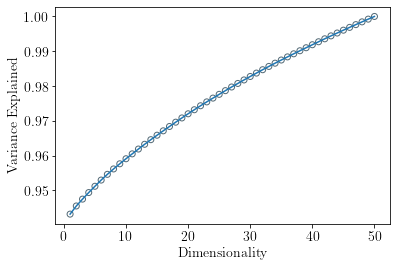

In [12]:
a = np.zeros(11726)
t = list(range(1,51))
b = np.sort(other_abs)
b = np.flip(b)
for i in range(len(b)):
    a[i]= a[i-1] + b[i] # comulative sum of the eigenvalues
a = a/np.sum(b[0:50])   # to get the explained variance ratio
print(a[0:50])
print(b[0:20])
np.sum(b[0:50])


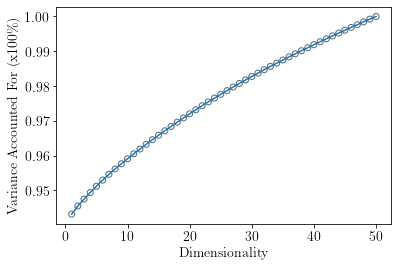

In [13]:
plt.plot(t,a[0:50])
plt.ylabel("Variance Accounted For (x100\%)")
plt.xlabel("Dimensionality")
plt.scatter(t, a[0:50], facecolors='none', edgecolors='#546A76')
plt.show()

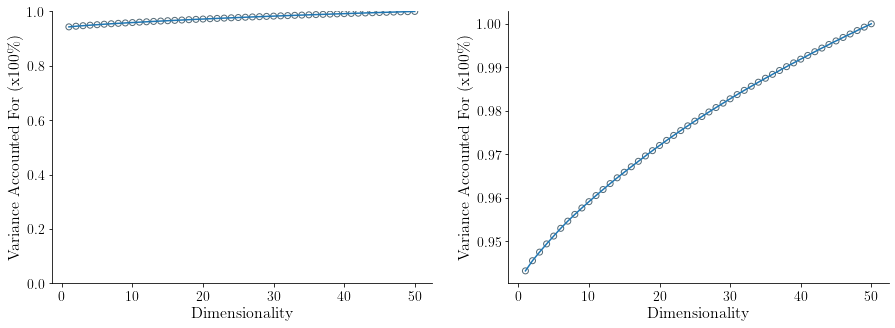

In [17]:
rc('text', usetex=True) 

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(t,a[0:50])
axs[0].scatter(t, a[0:50], facecolors='none', edgecolors='#546A76')
axs[0].set_xlabel('Dimensionality', fontsize=16)
axs[0].set_ylabel('Variance Accounted For (x100\%)', fontsize=16)
axs[0].set_ylim([0,1])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

axs[1].plot(t,a[0:50])
axs[1].scatter(t, a[0:50], facecolors='none', edgecolors='#546A76')
axs[1].set_xlabel('Dimensionality', fontsize=16)
axs[1].set_ylabel('Variance Accounted For (x100\%)', fontsize=16)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

In [14]:
print(np.flip(np.sort(w))[0:10])

[28576.79704358    70.85366154    59.86785747    57.08689901
    54.67549008    53.96749459    49.95799665    46.97078968
    44.85031052    43.90243388]


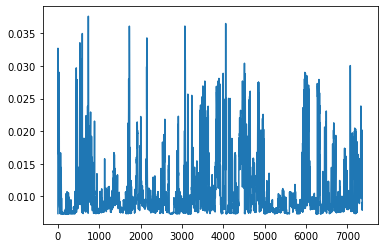

In [16]:
plt.plot(eig_vec[:, 0:1])
plt.show()

In [17]:
print(isomap.reconstruction_error())

2.953638080039291


(7363,)


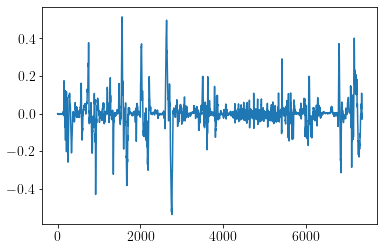

(1,)

In [28]:
data_vel.shape

summed_data = np.mean(data_vel, axis=1)
print(summed_data.shape)
plt.plot(summed_data)
plt.show()

latent.shape

In [32]:
print(latent[0][0])

-0.008737136031712786


In [33]:
new_latent = np.zeros(7363)
for i in range (0, len(new_latent)):
    new_latent[i] = latent[i][0]

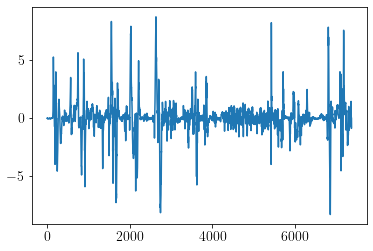

(7363,)

In [37]:
plt.plot(new_latent)
plt.show()
new_latent.shape

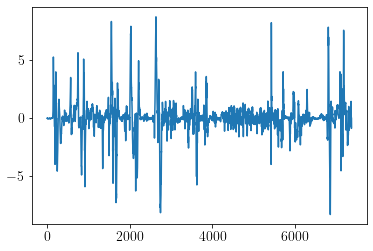

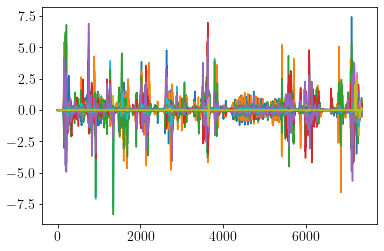

0.09552993385977958


In [42]:
plt.plot(latent)
plt.show()
plt.plot(data_vel)
plt.show()

# print(calculate_reconstruction_error(data_vel, latent))
# print(calculate_reconstruction_score(data_vel, latent))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(summed_data, new_latent)
print(std_err)


In [28]:
dim1_scores = np.zeros(69)
for i in range(69):
    score = calculate_reconstruction_error(data_vel[:,i], latent)
    dim1_scores[i] = score
print(np.argmin(dim1_scores))

31


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


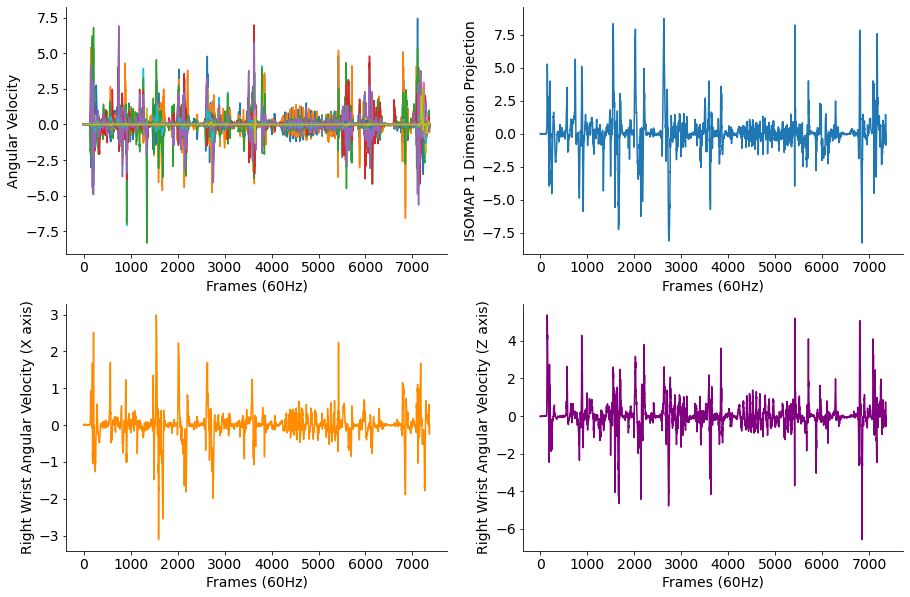

In [10]:
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].plot(data_vel)
axs[0,0].set_xlabel('Frames (60Hz)')
axs[0,0].set_ylabel('Angular Velocity', fontsize=14)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['top'].set_visible(False)

axs[0,1].plot(latent)
axs[0,1].set_xlabel('Frames (60Hz)', fontsize=14)
axs[0,1].set_ylabel('ISOMAP 1 Dimension Projection', fontsize=14)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['top'].set_visible(False)

axs[1,0].plot(data_vel[:,29], color='darkorange')
axs[1,0].set_xlabel('Frames (60Hz)', fontsize=14)
axs[1,0].set_ylabel('Right Wrist Angular Velocity (X axis)', fontsize=14)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)

axs[1,1].plot(data_vel[:,31], color='purple')
axs[1,1].set_xlabel('Frames (60Hz)', fontsize=14)
axs[1,1].set_ylabel('Right Wrist Angular Velocity (Z axis)', fontsize=14)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)


C:\Users\abdul\AppData\Local\Temp\ipykernel_32540\1429844737.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  arr.set_yticklabels(y_ticks, fontsize=14)


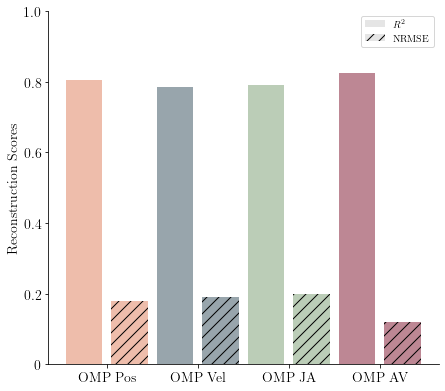

In [43]:
scores = [0.804, 0.18, 0.785, 0.19, 0.791, 0.2, 0.825, 0.12]

rc('text', usetex=True) 
hatches = ['', '//', '', '//', '', '//', '', '//']
colors = ['#E49273','#E49273','#546A76','#546A76','#8FAD88','#8FAD88','#92374D','#92374D']
f, arr = plt.subplots(1)
f.set_size_inches(7,6.5)
x_pos = np.arange(8)
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
x_mids = [0.5, 2.5, 4.5, 6.5]
x_words = ['OMP Pos', 'OMP Vel', 'OMP JA', 'OMP AV']

arr.bar(x_pos, scores, color = colors, hatch=hatches, alpha=0.6)

arr.set_xticks(x_mids, x_words, fontsize=14)
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.set_ylabel('Reconstruction Scores', fontsize=14)
arr.set_yticklabels(y_ticks, fontsize=14)
arr.set_ylim(0,1)
#arr.tick_params(labelbottom=False)
leg1 = mpatches.Patch(facecolor = "#808080", alpha=0.2, hatch="", label="$R^2$")
leg2 = mpatches.Patch(facecolor = "#808080", alpha=0.2, hatch="//", label="NRMSE")

arr.legend(handles=[leg1, leg2], fontsize=10)

In [64]:
lle = LLE(n_neighbors=20, n_components=5, method='modified')
lle.fit(data_vel)

LocallyLinearEmbedding(method='modified', n_components=5, n_neighbors=20)

0.055884802138104546


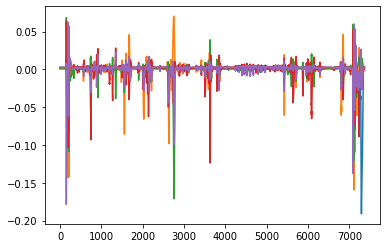

In [65]:
recon = lle.transform(data_vel)
print(lle.reconstruction_error_)
plt.plot(recon)
plt.show()